Compare opsim databases using TDEsMonteMetric

- [baseline2018](#baseline2018.db)
- [pontus_2573](#pontus_2573.db)
- [pontus_2579](#pontus_2579.db)
- [colossus_2667](#colossus_2667.db)
- [nexus_2097](#nexus_2097.db)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import healpy as hp
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db

# from mafContrib import TDEsAsciiMetric
from mycode import TDEsMonteMetric

In [2]:
# output directory
outDir = 'outdir'
resultsDb = db.ResultsDb(outDir=outDir)


In [3]:
# light curve file
asciifile = 'TDEfaintfast_z0.1.dat'

# query columns 
mjdCol = 'observationStartMJD'
m5Col = 'fiveSigmaDepth'
filterCol = 'filter'
detectSNR={'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5}

eventRate = 0.2
# light curve parameters
epochStart = -22
peakEpoch = 0
nearPeakT = 10
postPeakT = 14 # two weeks

# condition parameters
nObsTotal = {'u': 0, 'g': 0, 'r': 0, 'i': 0, 'z': 0, 'y': 0}
nObsPrePeak = 1
nObsNearPeak = {'u': 0, 'g': 0, 'r': 0, 'i': 0, 'z': 0, 'y': 0}
nFiltersNearPeak = 3
nObsPostPeak = 0 
nFiltersPostPeak = 2


In [4]:
# plot light curve
def plotlc(dataSlice, time_key='time', mag_key='mag', filter_key='filter', err_key = None,
          peakEpoch=None, nearPeakT=None, postPeakT=None):
    # Input: dataSlice, pandas DataFrame or numpy ndarray
    
    colors = {'u':'k', 'g':'b', 'r':'r', 'i':'m', 'z':'orange', 'y':'c'}
    
    plt.figure(figsize=(10, 6))
    for f in np.unique(dataSlice[filter_key]):
        fmatch = dataSlice[filter_key]==f
        time = dataSlice[time_key][fmatch]
        mag = dataSlice[mag_key][fmatch]
        
        # draw a vertical line to denote pre/near/post peak
        if peakEpoch!=None:
            plt.axvline(x=peakEpoch, linestyle='-', linewidth=1)
            plt.axvline(x=peakEpoch-nearPeakT/2, linestyle='--', linewidth=1)
            plt.axvline(x=peakEpoch+nearPeakT/2, linestyle='--', linewidth=1)
            plt.axvline(x=peakEpoch+nearPeakT/2+postPeakT, linestyle='--', linewidth=1)
        
        if err_key!=None:
            mag_err = dataSlice[err_key][fmatch]
            plt.errorbar(time, mag, yerr=mag_err, color=colors[f], fmt='.', label=f)
        else:
            plt.scatter(time, mag, color=colors[f], marker='*', label=f)

    plt.legend()
    plt.xlabel('days')
    plt.ylabel('mag')
    plt.ylim(plt.ylim()[::-1])
    

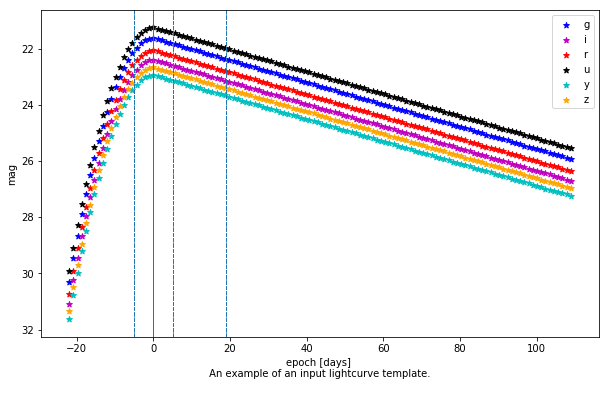

In [5]:
asciifile = 'TDEfaintfast_z0.1.dat'

lcv_template = np.genfromtxt(asciifile, dtype=[('ph', 'f8'), ('mag', 'f8'), ('flt', 'S1')])

df = pd.DataFrame()
df['ph'] = lcv_template['ph']
df['mag'] = lcv_template['mag']
df['flt'] = lcv_template['flt'].astype(str)

plotlc(df, time_key='ph', mag_key='mag', filter_key='flt', 
       peakEpoch=peakEpoch, nearPeakT=nearPeakT, postPeakT=postPeakT)

plt.xlabel('epoch [days] \n An example of an input lightcurve template. \n' )

## baseline2018.db

In [6]:
opsdb_baseline = db.OpsimDatabase('baseline2018a.db')
opsdb_baseline.fetchPropInfo()

({1: 'NorthEclipticSpur',
  2: 'SouthCelestialPole',
  3: 'WideFastDeep',
  4: 'GalacticPlane',
  5: 'DeepDrillingCosmology1'},
 {'WFD': [3], 'DD': [5], 'NES': [1]})

Finish initializing metric
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint night<730 and proposalId=3 for columns ['fieldRA', 'observationStartMJD', 'fieldDec', 'filter', 'fiveSigmaDepth']
Found 391886 visits
Running:  ['transmetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "night<730 and proposalId=3" constraint now.
monopole: 0.00773714  dipole: lon: -176.663, lat: -81.8168, amp: 0.0214241
Plotting complete.


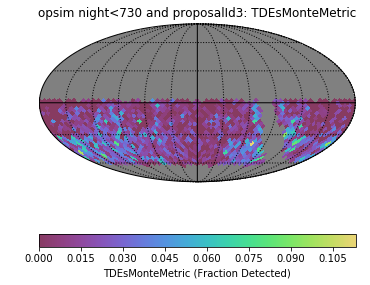

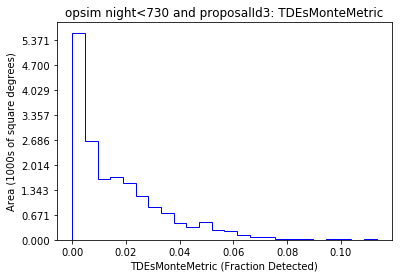

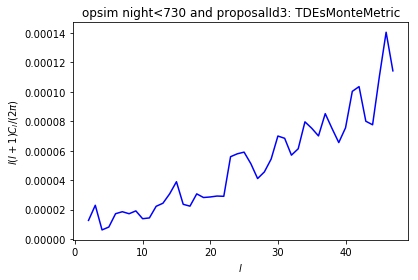

In [7]:
# get skymap by set dataout=False and use HealpixSlicer()
transmetric = TDEsMonteMetric(asciifile=asciifile, mjdCol=mjdCol, m5Col=m5Col, filterCol=filterCol, 
                              detectSNR=detectSNR, eventRate=eventRate,
                              epochStart=epochStart, peakEpoch=peakEpoch, 
                              nearPeakT=nearPeakT, postPeakT=postPeakT,
                              nObsTotal= nObsTotal, nObsPrePeak=nObsPrePeak, 
                              nObsNearPeak=nObsNearPeak, nFiltersNearPeak=nFiltersNearPeak, 
                              nObsPostPeak=nObsPostPeak, nFiltersPostPeak=nFiltersPostPeak,
                              dataout=False)

slicer = slicers.HealpixSlicer(nside=16) 
sqlconstraint = 'night<730 and proposalId=3'

transmetricSky = metricBundles.MetricBundle(transmetric,slicer,sqlconstraint)

group = metricBundles.MetricBundleGroup({'transmetricSky':transmetricSky}, opsdb_baseline, outDir=outDir, resultsDb=resultsDb)
group.runAll()
group.plotAll(closefigs=False)


In [8]:
baseline2018_skymap = transmetricSky.metricValues

# create a dataframe and save to csv file
df = pd.DataFrame(baseline2018_skymap)
df['ipix'] = df.index 
df['ra'] = hp.pix2ang(ipix=df['ipix'], nside=16, lonlat=True)[0]
df['dec'] = hp.pix2ang(ipix=df['ipix'], nside=16, lonlat=True)[1]
df['metricValues'] = df[0]
del df[0]
df.to_csv('./opsdb/baseline2018_skymap_TDEmc.csv', index=False, na_rep='NaN')

df.head()

,ipix,ra,dec,metricValues
0,0,45.0,87.075820,NaN
1,1,135.0,87.075820,NaN
2,2,225.0,87.075820,NaN
3,3,315.0,87.075820,NaN
4,4,22.5,84.149733,NaN


## pontus_2573

In [10]:
opsdb_pontus_2573 = db.OpsimDatabase('pontus_2573.db')
opsdb_pontus_2573.fetchPropInfo()

({1: 'NorthEclipticSpur',
  2: 'SouthCelestialPole',
  3: 'WideFastDeep',
  4: 'GalacticPlane',
  5: 'DeepDrillingCosmology1'},
 {'WFD': [3], 'DD': [5], 'NES': [1]})

Finish initializing metric
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint night<730 and proposalId=3 for columns ['fieldRA', 'observationStartMJD', 'fieldDec', 'filter', 'fiveSigmaDepth']
Found 377502 visits
Running:  ['transmetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "night<730 and proposalId=3" constraint now.
monopole: 0.100546  dipole: lon: 169.174, lat: -34.2577, amp: 0.0441959
Plotting complete.


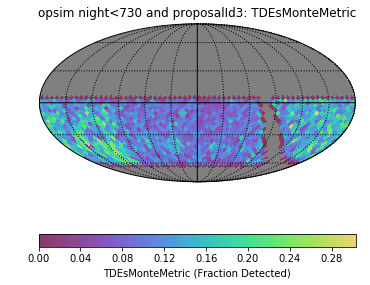

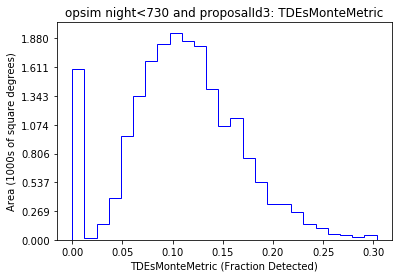

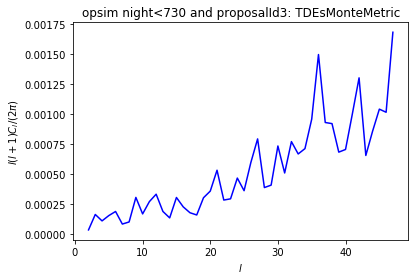

In [11]:
# get skymap by set dataout=False and use HealpixSlicer()
transmetric = TDEsMonteMetric(asciifile=asciifile, mjdCol=mjdCol, m5Col=m5Col, filterCol=filterCol, 
                              detectSNR=detectSNR, eventRate=eventRate,
                              epochStart=epochStart, peakEpoch=peakEpoch, 
                              nearPeakT=nearPeakT, postPeakT=postPeakT,
                              nObsTotal= nObsTotal, nObsPrePeak=nObsPrePeak, 
                              nObsNearPeak=nObsNearPeak, nFiltersNearPeak=nFiltersNearPeak, 
                              nObsPostPeak=nObsPostPeak, nFiltersPostPeak=nFiltersPostPeak,
                              dataout=False)

slicer = slicers.HealpixSlicer(nside=16) 
sqlconstraint = 'night<730 and proposalId=3'

transmetricSky = metricBundles.MetricBundle(transmetric,slicer,sqlconstraint)

group = metricBundles.MetricBundleGroup({'transmetricSky':transmetricSky}, opsdb_pontus_2573, outDir=outDir, resultsDb=resultsDb)
group.runAll()
group.plotAll(closefigs=False)

In [12]:
pontus_2573_skymap = transmetricSky.metricValues

# create a dataframe and save to csv file
df = pd.DataFrame(pontus_2573_skymap)
df['ipix'] = df.index 
df['ra'] = hp.pix2ang(ipix=df['ipix'], nside=16, lonlat=True)[0]
df['dec'] = hp.pix2ang(ipix=df['ipix'], nside=16, lonlat=True)[1]
df['metricValues'] = df[0]
del df[0]
df.to_csv('./opsdb/pontus_2573_skymap_TDEmc.csv', index=False, na_rep='NaN')

df.head()

,ipix,ra,dec,metricValues
0,0,45.0,87.075820,NaN
1,1,135.0,87.075820,NaN
2,2,225.0,87.075820,NaN
3,3,315.0,87.075820,NaN
4,4,22.5,84.149733,NaN


In [16]:
np.where(df.metricValues>=0.3)

(array([2112]),)

In [17]:
hp.pix2ang(ipix=2112, nside=16, lonlat=True)

(180.0, -22.02431283704216)

In [18]:
## get light curve by set dataout=True and use UserPointSlicer()
transmetric = TDEsMonteMetric(asciifile=asciifile, mjdCol=mjdCol, m5Col=m5Col, filterCol=filterCol, 
                              detectSNR=detectSNR, eventRate=eventRate,
                              epochStart=epochStart, peakEpoch=peakEpoch, 
                              nearPeakT=nearPeakT, postPeakT=postPeakT,
                              nObsTotal= nObsTotal, nObsPrePeak=nObsPrePeak, 
                              nObsNearPeak=nObsNearPeak, nFiltersNearPeak=nFiltersNearPeak, 
                              nObsPostPeak=nObsPostPeak, nFiltersPostPeak=nFiltersPostPeak,
                              dataout=True)
# ra,dec of ipix 
ra = np.array([180.0])
dec = np.array([-22.0243])
slicer = slicers.UserPointsSlicer(ra, dec)

sqlconstraint = 'night<730 and proposalId=3'
transmetricSky = metricBundles.MetricBundle(transmetric,slicer,sqlconstraint)

group = metricBundles.MetricBundleGroup({'transmetricSky':transmetricSky}, opsdb_pontus_2573, outDir=outDir, resultsDb=resultsDb)
group.runAll()


Finish initializing metric
Querying database SummaryAllProps with constraint night<730 and proposalId=3 for columns ['fieldRA', 'observationStartMJD', 'fieldDec', 'filter', 'fiveSigmaDepth']
Found 377502 visits
Running:  ['transmetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [20]:
# create a DataFrame from the output
output_dict_list = transmetricSky.metricValues.data[0] # 0 means 0th userpoint (ra,dec)
df = pd.DataFrame()
for d_ in output_dict_list:
    df = df.append(pd.DataFrame(d_))

# save to file
df.to_csv('./opsdb/pontus_2573_lc_TDEmc.csv', index=False)
df.head()

,detected,lcAboveThresh,lcEpoch,lcFilters,lcMags,lcMagsStd,lcMjd,lcN,lcSNR,m5,nearPeakCheck,postPeakCheck,prePeakCheck
0,True,False,-18.126562,r,27.964659,2.325524,60017.221285,0,0.133059,24.027341,False,False,True
1,True,False,-14.152384,u,24.846192,0.488569,60021.195463,0,1.759650,23.712333,False,False,True
2,True,True,-12.145694,r,24.710770,0.181320,60023.202153,0,5.501869,24.814621,False,False,True
3,True,False,-12.124398,i,25.041090,0.362870,60023.223449,0,2.519877,24.297113,False,False,True
4,True,True,-10.179236,i,24.264079,0.194380,60025.168611,0,5.100555,24.285698,False,False,True


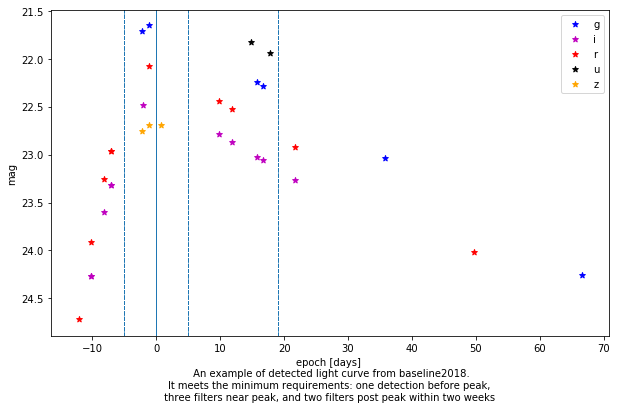

In [21]:
# load from csv
# df = pd.read_csv('./opsdb/baseline2018_lc.csv')

# plot all light curve
# plotlc(df[ (df['lcAboveThresh'])], time_key='expMJD', mag_key='lcMags', filter_key='filters', err_key='lcMagsStd')

# plot a specific light curve
plotlc(df[ (df.lcAboveThresh) & (df.lcN==0)], time_key='lcEpoch', mag_key='lcMags', filter_key='lcFilters', err_key=None, 
       peakEpoch=peakEpoch, nearPeakT=nearPeakT, postPeakT=postPeakT)

plt.xlabel('epoch [days] \n An example of detected light curve from baseline2018.\n' + 
           'It meets the minimum requirements: one detection before peak,\n three filters near peak, and two filters post peak within two weeks ')


## pontus_2579.db

In [37]:
opsdb_pontus_2579 = db.OpsimDatabase('pontus_2579.db')
opsdb_pontus_2579.fetchPropInfo()

({1: 'NorthEclipticSpur',
  2: 'SouthCelestialPole',
  3: 'WideFastDeep',
  4: 'GalacticPlane',
  5: 'DeepDrillingCosmology1'},
 {'WFD': [3], 'DD': [5], 'NES': [1]})

Finish initializing metric
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint night<730 and proposalId=3 for columns ['fieldRA', 'observationStartMJD', 'fieldDec', 'filter', 'fiveSigmaDepth']
Found 388502 visits
Running:  ['transmetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "night<730 and proposalId=3" constraint now.
monopole: 0.00830329  dipole: lon: -51.0596, lat: -40.0077, amp: 0.00472738
Plotting complete.


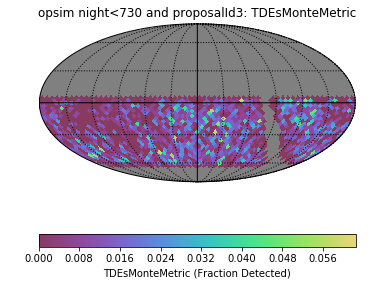

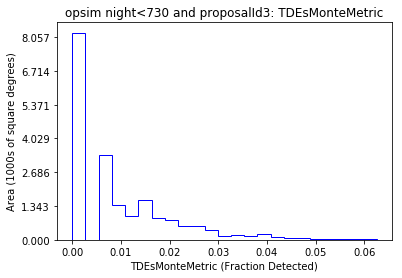

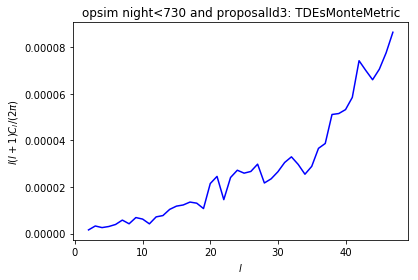

In [39]:
# get skymap by set dataout=False and use HealpixSlicer()
transmetric = TDEsMonteMetric(asciifile=asciifile, mjdCol=mjdCol, m5Col=m5Col, filterCol=filterCol, 
                              detectSNR=detectSNR, eventRate=eventRate,
                              epochStart=epochStart, peakEpoch=peakEpoch, 
                              nearPeakT=nearPeakT, postPeakT=postPeakT,
                              nObsTotal= nObsTotal, nObsPrePeak=nObsPrePeak, 
                              nObsNearPeak=nObsNearPeak, nFiltersNearPeak=nFiltersNearPeak, 
                              nObsPostPeak=nObsPostPeak, nFiltersPostPeak=nFiltersPostPeak,
                              dataout=False)

slicer = slicers.HealpixSlicer(nside=16) 
sqlconstraint = 'night<730 and proposalId=3'

transmetricSky = metricBundles.MetricBundle(transmetric,slicer,sqlconstraint)

group = metricBundles.MetricBundleGroup({'transmetricSky':transmetricSky}, opsdb_pontus_2579, outDir=outDir, resultsDb=resultsDb)
group.runAll()
group.plotAll(closefigs=False)



In [23]:
pontus_2579_skymap = transmetricSky.metricValues

# create a dataframe and save to csv file
df = pd.DataFrame(pontus_2579_skymap)
df['ipix'] = df.index 
df['ra'] = hp.pix2ang(ipix=df['ipix'], nside=16, lonlat=True)[0]
df['dec'] = hp.pix2ang(ipix=df['ipix'], nside=16, lonlat=True)[1]
df['metricValues'] = df[0]
del df[0]
df.to_csv('./opsdb/pontus_2579_skymap_TDEmc.csv', index=False, na_rep='NaN')

df.head()

,ipix,ra,dec,metricValues
0,0,45.0,87.075820,NaN
1,1,135.0,87.075820,NaN
2,2,225.0,87.075820,NaN
3,3,315.0,87.075820,NaN
4,4,22.5,84.149733,NaN


## pontus_2489

In [33]:
opsdb_pontus_2489 = db.OpsimDatabase('pontus_2489.db')
opsdb_pontus_2489.fetchPropInfo()

({1: 'GalacticPlane',
  2: 'NorthEclipticSpur',
  3: 'WideFastDeep',
  4: 'SouthCelestialPole',
  5: 'DeepDrillingCosmology1'},
 {'WFD': [3], 'DD': [5], 'NES': [2]})

Finish initializing metric
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint night<730 and proposalId=3 for columns ['fieldRA', 'observationStartMJD', 'fieldDec', 'filter', 'fiveSigmaDepth']
Found 574166 visits
Running:  ['transmetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "night<730 and proposalId=3" constraint now.
monopole: 0.0334513  dipole: lon: -175.179, lat: -31.9671, amp: 0.0189874
Plotting complete.


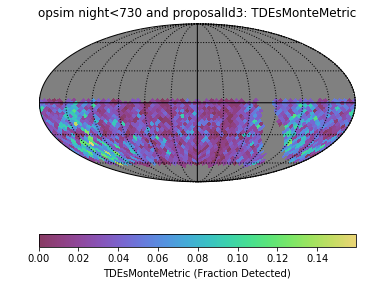

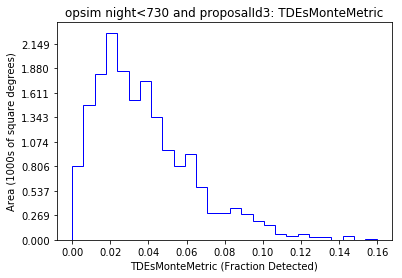

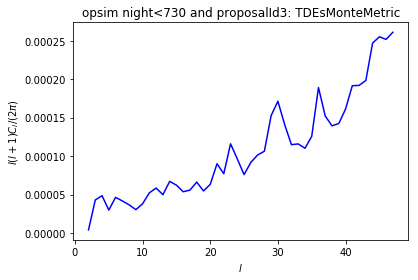

In [34]:
# get skymap by set dataout=False and use HealpixSlicer()
transmetric = TDEsMonteMetric(asciifile=asciifile, mjdCol=mjdCol, m5Col=m5Col, filterCol=filterCol, 
                              detectSNR=detectSNR, eventRate=eventRate,
                              epochStart=epochStart, peakEpoch=peakEpoch, 
                              nearPeakT=nearPeakT, postPeakT=postPeakT,
                              nObsTotal= nObsTotal, nObsPrePeak=nObsPrePeak, 
                              nObsNearPeak=nObsNearPeak, nFiltersNearPeak=nFiltersNearPeak, 
                              nObsPostPeak=nObsPostPeak, nFiltersPostPeak=nFiltersPostPeak,
                              dataout=False)

slicer = slicers.HealpixSlicer(nside=16) 
sqlconstraint = 'night<730 and proposalId=3'

transmetricSky = metricBundles.MetricBundle(transmetric,slicer,sqlconstraint)

group = metricBundles.MetricBundleGroup({'transmetricSky':transmetricSky}, opsdb_pontus_2489, outDir=outDir, resultsDb=resultsDb)
group.runAll()
group.plotAll(closefigs=False)


In [35]:
pontus_2489_skymap = transmetricSky.metricValues

# create a dataframe and save to csv file
df = pd.DataFrame(pontus_2489_skymap)
df['ipix'] = df.index 
df['ra'] = hp.pix2ang(ipix=df['ipix'], nside=16, lonlat=True)[0]
df['dec'] = hp.pix2ang(ipix=df['ipix'], nside=16, lonlat=True)[1]
df['metricValues'] = df[0]
del df[0]
df.to_csv('./opsdb/pontus_2489_skymap_TDEmc.csv', index=False, na_rep='NaN')

df.head()

,ipix,ra,dec,metricValues
0,0,45.0,87.075820,NaN
1,1,135.0,87.075820,NaN
2,2,225.0,87.075820,NaN
3,3,315.0,87.075820,NaN
4,4,22.5,84.149733,NaN


## colossus_2667.db

In [24]:
opsdb_colossus_2667 = db.OpsimDatabase('colossus_2667.db')
opsdb_colossus_2667.fetchPropInfo()

({1: 'WideFastDeep',
  2: 'GalacticPlane',
  3: 'SouthCelestialPole',
  4: 'NorthEclipticSpur',
  5: 'DeepDrillingCosmology1'},
 {'WFD': [1], 'DD': [5], 'NES': [4]})

Finish initializing metric
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint night<730 and proposalId=1 for columns ['fieldRA', 'observationStartMJD', 'fieldDec', 'filter', 'fiveSigmaDepth']
Found 411558 visits
Running:  ['transmetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "night<730 and proposalId=1" constraint now.
monopole: 0.0536408  dipole: lon: 154.683, lat: -46.4287, amp: 0.01145
Plotting complete.


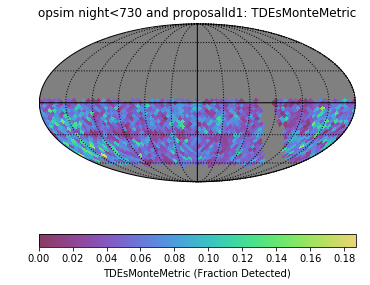

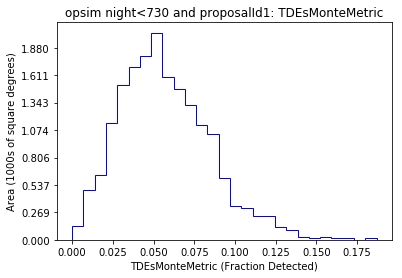

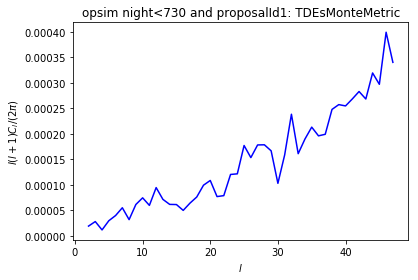

In [25]:
# get skymap by set dataout=False and use HealpixSlicer()
transmetric = TDEsMonteMetric(asciifile=asciifile, mjdCol=mjdCol, m5Col=m5Col, filterCol=filterCol, 
                              detectSNR=detectSNR, eventRate=eventRate,
                              epochStart=epochStart, peakEpoch=peakEpoch, 
                              nearPeakT=nearPeakT, postPeakT=postPeakT,
                              nObsTotal= nObsTotal, nObsPrePeak=nObsPrePeak, 
                              nObsNearPeak=nObsNearPeak, nFiltersNearPeak=nFiltersNearPeak, 
                              nObsPostPeak=nObsPostPeak, nFiltersPostPeak=nFiltersPostPeak,
                              dataout=False)

slicer = slicers.HealpixSlicer(nside=16) 
sqlconstraint = 'night<730 and proposalId=1'

transmetricSky = metricBundles.MetricBundle(transmetric,slicer,sqlconstraint)

group = metricBundles.MetricBundleGroup({'transmetricSky':transmetricSky}, opsdb_colossus_2667, outDir=outDir, resultsDb=resultsDb)
group.runAll()
group.plotAll(closefigs=False)

colossus_skymap = transmetricSky.metricValues

In [26]:
# create a dataframe and save to csv file
df = pd.DataFrame(colossus_skymap)
df['ipix'] = df.index 
df['ra'] = hp.pix2ang(ipix=df['ipix'], nside=16, lonlat=True)[0]
df['dec'] = hp.pix2ang(ipix=df['ipix'], nside=16, lonlat=True)[1]
df['metricValues'] = df[0]
del df[0]
df.to_csv('./opsdb/colossus_skymap_TDEmc.csv', index=False, na_rep='NaN')

df.head()

,ipix,ra,dec,metricValues
0,0,45.0,87.075820,NaN
1,1,135.0,87.075820,NaN
2,2,225.0,87.075820,NaN
3,3,315.0,87.075820,NaN
4,4,22.5,84.149733,NaN


## nexus_2097.db

In [27]:
opsdb_nexus_2097 = db.OpsimDatabase('nexus_2097.db')
opsdb_nexus_2097.fetchPropInfo()

({1: 'WideFastDeep', 2: 'DeepDrillingCosmology1'},
 {'WFD': [1], 'DD': [2], 'NES': []})

Finish initializing metric
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint night<730 and proposalId=1 for columns ['fieldRA', 'observationStartMJD', 'fieldDec', 'filter', 'fiveSigmaDepth']
Found 444918 visits
Running:  ['transmetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "night<730 and proposalId=1" constraint now.
monopole: 0.00396613  dipole: lon: 116.912, lat: -45.7722, amp: 0.00455973
Plotting complete.


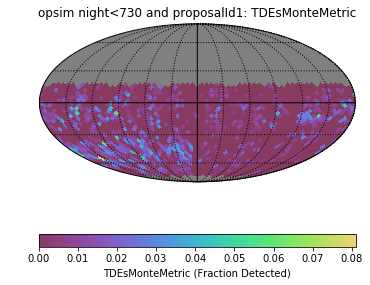

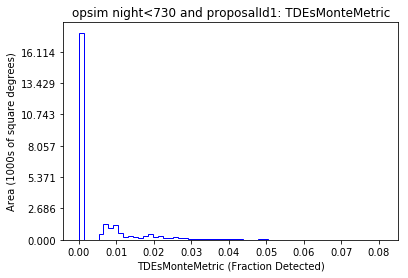

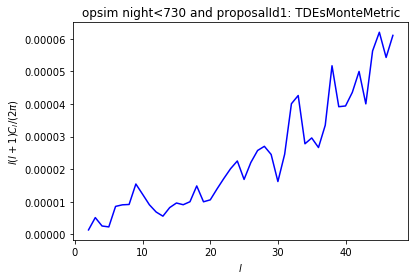

In [28]:
# get skymap by set dataout=False and use HealpixSlicer()
transmetric = TDEsMonteMetric(asciifile=asciifile, mjdCol=mjdCol, m5Col=m5Col, filterCol=filterCol, 
                              detectSNR=detectSNR, eventRate=eventRate,
                              epochStart=epochStart, peakEpoch=peakEpoch, 
                              nearPeakT=nearPeakT, postPeakT=postPeakT,
                              nObsTotal= nObsTotal, nObsPrePeak=nObsPrePeak, 
                              nObsNearPeak=nObsNearPeak, nFiltersNearPeak=nFiltersNearPeak, 
                              nObsPostPeak=nObsPostPeak, nFiltersPostPeak=nFiltersPostPeak,
                              dataout=False)

slicer = slicers.HealpixSlicer(nside=16) 
sqlconstraint = 'night<730 and proposalId=1'

transmetricSky = metricBundles.MetricBundle(transmetric,slicer,sqlconstraint)

group = metricBundles.MetricBundleGroup({'transmetricSky':transmetricSky}, opsdb_nexus_2097, outDir=outDir, resultsDb=resultsDb)
group.runAll()
group.plotAll(closefigs=False)


In [29]:
nexus_skymap = transmetricSky.metricValues

# create a dataframe and save to csv file
df = pd.DataFrame(nexus_skymap)
df['ipix'] = df.index 
df['ra'] = hp.pix2ang(ipix=df['ipix'], nside=16, lonlat=True)[0]
df['dec'] = hp.pix2ang(ipix=df['ipix'], nside=16, lonlat=True)[1]
df['metricValues'] = df[0]
del df[0]
df.to_csv('./opsdb/nexus_skymap_TDEmc.csv', index=False, na_rep='NaN')

df.head()

,ipix,ra,dec,metricValues
0,0,45.0,87.075820,NaN
1,1,135.0,87.075820,NaN
2,2,225.0,87.075820,NaN
3,3,315.0,87.075820,NaN
4,4,22.5,84.149733,NaN


In [36]:
df_sum = pd.DataFrame()
df_sum['Opsim'] = ['baseline2018', 'colossus_2667', 'pontus_2573', 'pontus_2579','pontus_2489', 'nexus_2097']
df_sum['comment'] = ['official baseline', 'single visits', 'mixed filter pairs', 'rolling cadence', 'more visits', 'rolling large WFD']
df_sum['nights'] = [730, 730, 730, 730, 730, 730]
df_sum['Fraction Detected'] = [0.008, 0.05, 0.1, 0.1, 0.03, 0.004]
df_sum



,Opsim,comment,nights,Fraction Detected
0,baseline2018,official baseline,730,0.008
1,colossus_2667,single visits,730,0.050
2,pontus_2573,mixed filter pairs,730,0.100
3,pontus_2579,rolling cadence,730,0.100
4,pontus_2489,more visits,730,0.030
5,nexus_2097,rolling large WFD,730,0.004
